## Portfolio Exercise Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their candidates.   The data for this exercise consists of about 120,000 data points split in 2:1 ratio among training and test files. Each data point includes one column indicating whether or not an individual was sent a promotion for a specific product, and one column indicating whether or not that individual eventually purchased that product. Each individual also had seven additional features associated with them.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user.  Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

Ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group.

* **Net Incremental Revenue (NIR)**

The total number of purchasers that received the promotion times 10 minus the number of promotions given times 0.15 minus the number of purchasers who were not given the promotion times 10.

For a full description of what starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the **promotion_strategy** function to pass to the **test_results** function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers.  

|   | Actual      |    |    | 
|---|-------------|----|----|
| **Predicted**   | Yes| No |  
| Yes             | **I**   | **II**|  
| No              | **III** | **IV**|  

The metrics are only being compared for the individual's we predict should obtain the promotion - that is quadrants I and II here.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equal participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 


Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final test_results function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from imblearn.over_sampling import SMOTE

import scipy.stats as stats
from statsmodels.stats import proportion as proptests
import statsmodels.api as sm
from statsmodels.tools import add_constant

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load in the data
train_data = pd.read_csv('data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [2]:
train_data.shape

(84534, 10)

In [3]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

## Analyze the result of the experinment and identify effect of the treatment for key metrics 

- IRR
- NIR


In [4]:
# explorative analysis
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [5]:
train_data.groupby('Promotion').agg({'purchase':'mean'})

,purchase
Promotion,
No,0.007565
Yes,0.017019


In [6]:
# treatment group and control group 
# first, make sure two groups are approximately the same 

train_t = train_data[train_data['Promotion'] == 'Yes']
train_c = train_data[train_data['Promotion'] == 'No']
print(train_t.shape[0],train_c.shape[0])

42364 42170


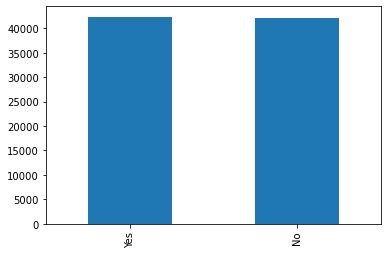

In [7]:
# Visualize 
train_data['Promotion'].value_counts().plot(kind = 'bar')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff44c545610>,
      dtype=object)

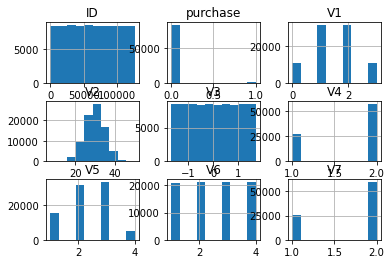

In [8]:
train_data.hist()

In [9]:
# Sanity check: test if proportion of two groups are approximately 0.5 vs 0.5
def proportion_test(count,nobs):
    p_val = proptests.binom_test(
        count+0.5,
        nobs,
        prop =0.5,
        alternative = 'two-sided'
    )
    
    if p_val < 0.05:
        print(f'P-value: {round(p_val,3)} - Statistically significant; reject H0.')
    else:
        print(f'P-value: {round(p_val,3)} - Fail to reject H0; two groups have roughly same # of observations.')

proportion_test(train_t.shape[0], train_data.shape[0])

P-value: 0.507 - Fail to reject H0; two groups have roughly same # of observations.


In [10]:
# Identified promotion's effect on IRR 

# Ho: IRRs of treatment group and control group has no difference 

x_treat = train_t['purchase'].sum() 
x_cont = train_c['purchase'].sum() 
n_treat = train_t.shape[0]
n_cont = train_c.shape[0]
N = train_data.shape[0]

def test_irr(x_cont, x_exp, n_cont, n_exp, N, alpha = 0.05, diff_null = 0, if_test = True):

    p_cont = x_cont / n_cont
    p_exp = x_exp / n_exp
    p_pool = (x_cont+x_exp)/N 
    
    se_pool = np.sqrt(
        (p_pool*(1-p_pool))*((1/n_cont)+(1/n_exp))
    )

    z_test = ((p_exp - p_cont) - diff_null)/se_pool
    #p_val = stats.norm.sf(abs(z_test))
    p_val = 1-stats.norm.cdf(z_test)

    
    print(f'IRR_treat: {round(p_exp,3)}\nIRR_control: {round(p_cont,3)}\nIRR_diff: {round(p_exp - p_cont,3)}')

    if if_test == True:
        if p_val > alpha:
            print(f'P-value: {round(p_val,5)}\nZ-score: {round(z_test,3)}\nFail to reject H0; There is no significant difference.')
        else:
            print(f'P-value: {round(p_val,5)}\nZ-score: {round(z_test,3)}\nReject H0; There is a significant difference.')

test_irr(x_cont, x_treat, n_cont, n_treat, N, if_test = True)

IRR_treat: 0.017
IRR_control: 0.008
IRR_diff: 0.009
P-value: 0.0
Z-score: 12.468
Reject H0; There is a significant difference.


In [11]:
# Identified promotion's effect on NIR

price = 10
cost = 0.15

rev_treat = price*x_treat - cost*n_treat
rev_cont = price*x_cont
print(f'Revenue of treatment group: {rev_treat}\nRevenue of control group: {rev_cont}\nNIR: {rev_treat - rev_cont}')


Revenue of treatment group: 855.4000000000005
Revenue of control group: 3190
NIR: -2334.5999999999995


## Logistic regression

In [12]:
# first add an constant 
#train_data = add_constant(train_data)
train_data['Promotion'] = train_data['Promotion'].replace({'Yes':1, 'No':0})

In [13]:
# use training set to train the model 

X = train_data.drop([   
    'ID','Promotion','purchase'
], axis=1)

y = train_data['purchase']

# check feature significance by implementing model before we built and fit one 
log_mod = sm.Logit(y,X)
result = log_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.068131
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: -0.027    
Dependent Variable: purchase         AIC:              11532.6884
Date:               2020-12-11 09:41 BIC:              11598.1028
No. Observations:   84534            Log-Likelihood:   -5759.3   
Df Model:           6                LL-Null:          -5607.4   
Df Residuals:       84527            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
V1       -0.1896     0.0342    -5.5361   0.0000   -0.2567   -0.1225
V2       -0.0870     0.0045   -19.4562   0.0000   -0.0957   -0.0782
V3       -0.0527     0.0302    -1.7467   0.0807   -0.1119    0.0064
V4        0.0511     0.0588     0.8690   0.3849   -0.0642    0.1665
V5       -0.1513     0.0340    -4.4484   0.0000   -0.2180   -0.0846
V6       -0.1567     0.0264    -5.9425   0.0000   -0.2083   -0.1050
V7       -0.5428     0.0565    -9.6143   0.0000   -0.6534   -0.4321
=================================================================

"""

## Promotion Strategy Optimization


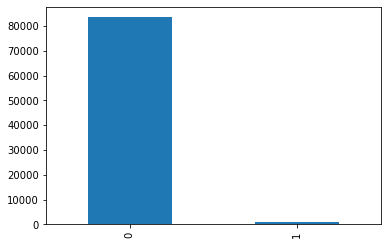

In [14]:

# However, since the data we have is severely imbalance, we need to over-sample minority group (customers who purchased)
train_data['purchase'].value_counts().plot(kind = 'bar')

In [27]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

def resample_df(X_train, y_train):
    X = pd.concat([X_train, y_train], axis=1)
    purchase_1= X[X.purchase == 1]
    purchase_0 = X[X.purchase == 0]

    purchase_0_resample = resample(
        purchase_0,
        replace = True,
        n_samples = purchase_1.shape[0],
        random_state = 42
    )

    balanced = pd.concat([purchase_0_resample,purchase_1])

    X_train = balanced.drop('purchase',axis = 1)
    y_train = balanced.purchase

    return balanced, X_train, y_train

balanced_df, X_train, y_train = resample_df(X_train,y_train)




In [28]:
print(balanced_df.purchase.value_counts())

1    719
0    719
Name: purchase, dtype: int64


In [29]:
# Standarize X
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Model 1: Logistic Regression

In [30]:

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train) # fit the model 

# predict
y_predict = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)
print(f'Test Accuracy: {log_reg.score(X_test,y_test)}\nTrain Accuracy: {log_reg.score(X_train,y_train)}')

Test Accuracy: 0.4508891605220614
Train Accuracy: 0.5771905424200278


In [31]:
# probability of being 0 and 1 
y_prob = pd.DataFrame(y_prob)
y_prob.head()

,0,1
0,0.399328,0.600672
1,0.446541,0.553459
2,0.332140,0.667860
3,0.486301,0.513699
4,0.605026,0.394974


In [32]:
# confusion matrix 

matrix = confusion_matrix(y_test, y_predict)
print(matrix)

[[11226 13814]
 [  112   209]]


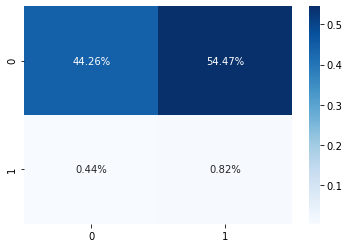

In [33]:

sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%',cmap='Blues')

## Model 2: Supportive Vector 

In [50]:

# It's computational expensive!

# clf = SVC(kernel='rbf',probability=True)
# clf.fit(X_train,y_train)
# y_predict2= clf.predict(X_test)
# y_prob2 = clf.predict_proba(X_test)


In [51]:
# probability of being 0 and 1 
y_prob2 = pd.DataFrame(y_prob2)
y_prob2.head()

,0,1
0,0.719370,0.280630
1,0.434342,0.565658
2,0.645081,0.354919
3,0.721107,0.278893
4,0.657881,0.342119


In [54]:

print(f'Test Accuracy: {clf.score(X_test,y_test)}\nTrain Accuracy: {clf.score(X_train,y_train)}')

Test Accuracy: 0.5616892078388076
Train Accuracy: 0.6346528894515345


[[14087 10953]
 [  163   158]]


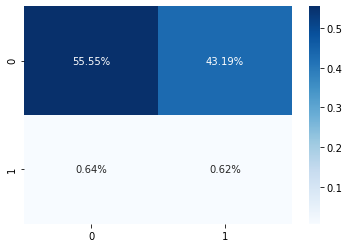

In [146]:
matrix2 = confusion_matrix(y_test, y_predict2)
print(matrix2)

sns.heatmap(matrix2/np.sum(matrix2), annot=True, fmt='.2%',cmap='Blues')

## Model 3: Decision Tree

In [36]:

dtree = DecisionTreeClassifier(random_state=42, max_depth=4)
dtree.fit(X_train, y_train)
y_predict3 = dtree.predict(X_test)
y_prob3 = dtree.predict_proba(X_test)

print(f'Test Accuracy: {dtree.score(X_test,y_test)}\nTrain Accuracy: {dtree.score(X_train,y_train)}')


Test Accuracy: 0.6014747052561019
Train Accuracy: 0.6223922114047288


In [37]:
y_prob3 = pd.DataFrame(y_prob3)
y_prob3.head()

,0,1
0,0.500000,0.500000
1,0.389571,0.610429
2,0.389571,0.610429
3,0.764706,0.235294
4,0.660436,0.339564


[[15078  9962]
 [  145   176]]


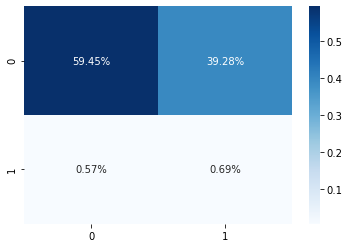

In [38]:
matrix3 = confusion_matrix(y_test, y_predict3)
print(matrix3)
sns.heatmap(matrix3/np.sum(matrix3), annot=True, fmt='.2%',cmap='Blues')

In [ ]:
# Overall, decision tree model outperforms. We can therefore use decision tree to refit entire training set and predict test set

## Refit champion model with entire train data, and predict values for test data

In [39]:
test_data = pd.read_csv('data/Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [41]:
# data preparation

X_train_data = train_data.drop(['ID','Promotion','purchase'],axis = 1)
y_train_data = train_data['purchase']

train_balanced, X_train_data, y_train_data = resample_df(
    X_train_data,y_train_data
)

In [44]:
train_balanced.purchase.value_counts()

1    1040
0    1040
Name: purchase, dtype: int64

In [45]:
X_train_data = StandardScaler().fit_transform(X_train_data)

X_test_data = test_data.drop(['ID','Promotion','purchase'],axis = 1)
X_test_data = StandardScaler().fit_transform(X_test_data)
y_test_data = test_data['purchase']

In [78]:
# refit model 

dtree.fit(X_train_data, y_train_data)
y_predict4 = dtree.predict(X_test_data)
y_prob4 = dtree.predict_proba(X_test_data)

print(f'Test Accuracy: {dtree.score(X_test_data,y_test_data)}\nTrain Accuracy: {dtree.score(X_train,y_train)}')

Test Accuracy: 0.5045138055222089
Train Accuracy: 0.5980528511821975


In [79]:
dtree.feature_importances_

array([0.0223998 , 0.1535303 , 0.15192176, 0.33953521, 0.27702438,
       0.03050264, 0.02508591])

[[20667 20503]
 [  134   346]]


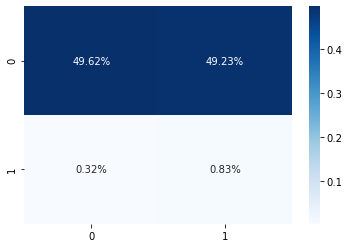

In [80]:
matrix4 = confusion_matrix(y_test_data, y_predict4)
print(matrix4)
sns.heatmap(matrix4/np.sum(matrix4), annot=True, fmt='.2%',cmap='Blues')

In [81]:
y_test_pred = pd.DataFrame(y_predict4, columns=['purchase_pred'])
y_test_prob = pd.DataFrame(y_prob4)

result = pd.concat([test_data.iloc[:,0:3],pd.concat([y_test_pred,y_test_prob], axis = 1)],axis = 1)
result['Promotion_pred'] = result['purchase_pred'].replace({0:'No',1:'Yes'})
result.head()


,ID,Promotion,purchase,purchase_pred,0,1,Promotion_pred
0,2,No,0,0,0.617886,0.382114,No
1,6,Yes,0,0,0.636964,0.363036,No
2,7,Yes,0,1,0.421687,0.578313,Yes
3,10,No,0,1,0.359667,0.640333,Yes
4,12,No,0,0,0.636964,0.363036,No


In [83]:
# IRR

x_treat = result.loc[result.Promotion_pred == 'Yes', 'purchase'].sum() 
x_cont = result.loc[result.Promotion_pred == 'No', 'purchase'].sum() 
n_treat = result.loc[result.Promotion_pred == 'Yes'].shape[0]
n_cont = result.loc[result.Promotion_pred == 'No'].shape[0]
N = result.shape[0]

test_irr(x_cont, x_treat, n_cont, n_treat, N, False)


IRR_treat: 0.017
IRR_control: 0.006
IRR_diff: 0.01
P-value: 0.0
Z-score: 9.707
Reject H0; There is a significant difference.


In [86]:
price = 10
cost = 0.15

rev_treat = price*x_treat - cost*n_treat
rev_cont = price*x_cont
print(f'Revenue of treatment group: {rev_treat}\nRevenue of control group: {rev_cont}\nNIR: {rev_treat - rev_cont}')

Revenue of treatment group: 332.6500000000001
Revenue of control group: 1340
NIR: -1007.3499999999999


In [20]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    
    
    
    return promotion

In [69]:
# This will test your results, and provide you back some information 
# on your how well your promotion_strategy will work in practice

test_results(promotion_strategy)